In [12]:
import pandas as pd
from nuance import Nuance
import sys
import jax.numpy as jnp
import yaml

sys.path.append("../lib")
import utils
import numpy as np

df = pd.read_csv("../data/lightcurves/P10.0_R0.5_1412.5708862326005.csv")
time, flux, error = df.values.T
time -= time[0]

X = utils.poly_X(time, 3)

nu = Nuance(time, flux, np.mean(error), X=X, compute=False)

period = 17.0 / 24.0

init_params = {
    "log_omega": jnp.log(2 * jnp.pi / period),
    "log_quality": jnp.log(50.0),
    "log_sigma": jnp.log(np.std(flux)),
    "log_jitter": jnp.log(np.mean(error)),
}

# Masked optimization (for flares and transits)
mask = np.ones_like(nu.time).astype(bool)
new_params = init_params.copy()
window = 30

for i in range(3):
    if i == 0:
        m = np.mean(flux)
    else:
        m = np.array(mu(new_params))
    r = flux - m
    mask_up = r < np.std(r[mask]) * 3
    mask_down = r > -np.std(r[mask]) * 2

    # mask around flares
    ups = np.flatnonzero(~mask_up)
    if len(ups) > 0:
        mask_up[
            np.hstack(
                [
                    np.arange(max(u - window, 0), min(u + window, len(nu.time)))
                    for u in ups
                ]
            )
        ] = False
    mask = np.logical_and(mask_up, mask_down)

    optimize, mu, plot_kernel = nu.gp_optimization(utils.build_gp, mask=mask)
    new_params = optimize(new_params, ["log_sigma", "log_jitter"])
    new_params = optimize(new_params, ["log_quality", "log_sigma", "log_jitter"])
    new_params = optimize(new_params)

# Saving

final_params = {
    "log_omega": float(new_params["log_omega"]),
    "log_quality": float(new_params["log_quality"]),
    "log_jitter": float(new_params["log_jitter"]),
    "log_sigma": float(new_params["log_sigma"]),
}

yaml.safe_dump(final_params, open("../data/gp2.yaml", "w"))


ScipyMinimizeInfo(fun_val=DeviceArray(-141208.89407841, dtype=float64, weak_type=True), success=True, status=0, iter_num=7)
ScipyMinimizeInfo(fun_val=DeviceArray(-141228.65904733, dtype=float64, weak_type=True), success=False, status=2, iter_num=3)
ScipyMinimizeInfo(fun_val=DeviceArray(-141337.18378439, dtype=float64, weak_type=True), success=True, status=0, iter_num=15)
ScipyMinimizeInfo(fun_val=DeviceArray(-128644.74447113, dtype=float64, weak_type=True), success=True, status=0, iter_num=7)
ScipyMinimizeInfo(fun_val=DeviceArray(-128645.01418668, dtype=float64, weak_type=True), success=True, status=0, iter_num=6)
ScipyMinimizeInfo(fun_val=DeviceArray(-128645.339502, dtype=float64, weak_type=True), success=True, status=0, iter_num=9)
ScipyMinimizeInfo(fun_val=DeviceArray(-123250.40506116, dtype=float64, weak_type=True), success=True, status=0, iter_num=8)
ScipyMinimizeInfo(fun_val=DeviceArray(-123250.50389807, dtype=float64, weak_type=True), success=True, status=0, iter_num=7)
ScipyMin

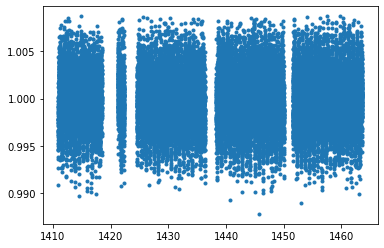

In [11]:
import matplotlib.pyplot as plt

df = pd.read_csv("../data/lightcurves/P10.0_R0.5_1412.5708862326005.csv")
time, flux, error = df.values.T
plt.plot(time, flux, ".")